In [46]:
CONFIG_PATH = '../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

In [47]:
# Load config
import json
import numpy as np
from pathlib import Path

### Подготавливаем визуализацию

In [48]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes

/alpha/projects/wastie/code/kondrashov/delta/notes


In [49]:
# Create temporary directory for predictions
pred_labels_dir = Path('runs/segment/predict/labels')
pred_images_dir = Path('runs/segment/predict')

In [50]:
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

In [51]:
from matplotlib import pyplot as plt
import numpy as np

In [52]:
def group_len(g, border=True):
    return len([1 for m in g if border or not m['is_border']])
def group_matches(g, border=True):
    return sum(m['is_matched'] for m in g if border or not m['is_border'])
def calculate_integrated_precision(pred_groups, int_thr, border=True):
    matches = len([1 for g in pred_groups if group_matches(g, border) > 0 and group_len(g, border) >= int_thr])
    total = len([1 for g in pred_groups if group_len(g, border) >= int_thr])
    return matches / total

def calculate_integrated_recall(gt_groups, int_thr, border=True):
    matches = len([1 for g in gt_groups if group_matches(g, border) >= int_thr])
    total = len(gt_groups)
    return matches / total

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_match_probability(groupset, title):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])

    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)

    # Create bins and calculate probabilities
    bins = np.linspace(area_shares.min(), area_shares.max(), 16)
    bin_indices = np.digitize(area_shares, bins) - 1
    probabilities = []
    bin_centers = []

    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            prob = np.mean(is_matched[mask])
            probabilities.append(prob)
            bin_centers.append((bins[i] + bins[i+1]) / 2)

    # Apply Gaussian smoothing
    probabilities = np.array(probabilities)
    smoothed_probabilities = gaussian_filter(probabilities, sigma=2)

    # Plot probability distribution
    plt.plot(bin_centers, probabilities, 'o', alpha=0.3, label='Raw data')
    plt.plot(bin_centers, smoothed_probabilities, '-', label='Smoothed')
    plt.ylim(0, 1)
    plt.xlabel('Area Share')
    plt.ylabel('Probability of Match')
    plt.title(f'Probability of Match vs Area Share - {title}')
    plt.grid(True)
    plt.legend()


In [54]:
def plot_area_distribution(gt_groups, pred_groups, config):
    # Plot area distribution histograms
    plt.figure(figsize=(15, 6))

    # Ground Truth histogram
    plt.subplot(1, 2, 1)
    gt_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in gt_groups 
                for instance in group]
    plt.hist(gt_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Ground Truth')
    plt.grid(True)

    # Predictions histogram
    plt.subplot(1, 2, 2)
    pred_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in pred_groups 
                for instance in group]
    plt.hist(pred_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [55]:
from scipy import stats

def get_correlation_data(groupset):
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    return np.array(area_shares), np.array(is_matched)

def calculate_pcorr(gt_groups, pred_groups):
    # Get data for GT and Pred
    gt_areas, gt_matched = get_correlation_data(gt_groups)
    pred_areas, pred_matched = get_correlation_data(pred_groups)

    # Combine data for total
    total_areas = np.concatenate([gt_areas, pred_areas])
    total_matched = np.concatenate([gt_matched, pred_matched])

    # Calculate correlations and p-values
    gt_corr, gt_pval = stats.pearsonr(gt_areas, gt_matched)
    pred_corr, pred_pval = stats.pearsonr(pred_areas, pred_matched)
    total_corr, total_pval = stats.pearsonr(total_areas, total_matched)

    # Print results in a formatted table
    print(f"{'Dataset':<10} {'Correlation':>12} {'P-value':>12}")
    print("-" * 34)
    print(f"{'GT':<10} {gt_corr:>12.4f} {gt_pval:>12.4e}")
    print(f"{'Pred':<10} {pred_corr:>12.4f} {pred_pval:>12.4e}")
    print(f"{'Total':<10} {total_corr:>12.4f} {total_pval:>12.4e}")

In [56]:
def get_match_probability(groupset, a, b):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    
    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)
    
    # Find objects within the specified range
    mask = (area_shares >= a) & (area_shares <= b)
    
    # Calculate probability if there are objects in the range
    if np.sum(mask) > 0:
        probability = np.mean(is_matched[mask])
        return probability
    else:
        return None

## Разреженный тест

In [57]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes

/alpha/projects/wastie/code/kondrashov/delta/notes


In [58]:
import pickle
with open('../groups/gt_test_sparse.pkl', 'rb') as f:
    gt_groups = pickle.load(f)
with open('../groups/pred_test_sparse.pkl', 'rb') as f:
    pred_groups = pickle.load(f)

Median group size: 22
Mean group size: 21


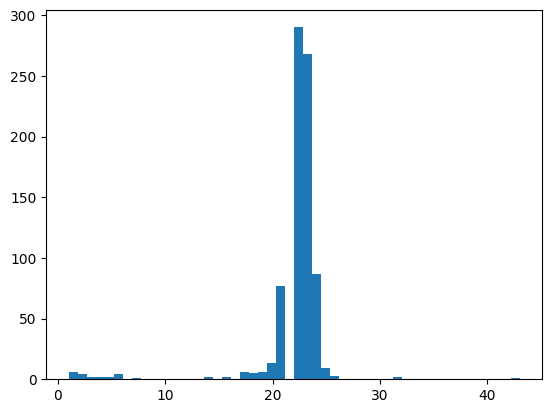

In [59]:
plt.hist([len(g) for g in gt_groups], bins=50)
median_length = int(np.median([len(g) for g in gt_groups]))
mean_length = int(np.mean([len(g) for g in gt_groups]))
print(f"Median group size: {median_length}")
print(f"Mean group size: {mean_length}")

In [60]:
len_is_matched = []
len_not_matched = []
for g in pred_groups:
    is_matched = any(obj['is_matched'] for obj in g)
    if is_matched:
        len_is_matched.append(len(g))
    else:
        len_not_matched.append(len(g))

Median group size: 21
Mean group size: 17


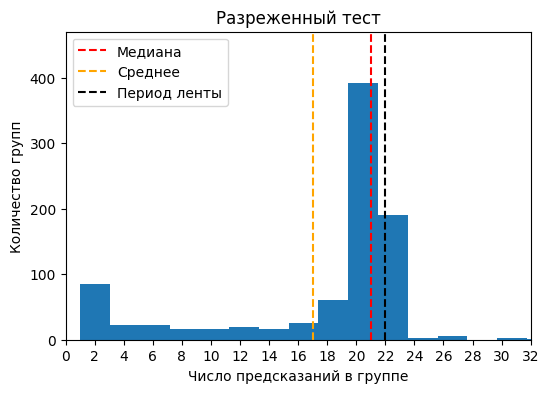

In [61]:
pred_median_length = int(np.median([len(g) for g in pred_groups]))
pred_mean_length = int(np.mean([len(g) for g in pred_groups]))
print(f"Median group size: {pred_median_length}")
print(f"Mean group size: {pred_mean_length}")

plt.figure(figsize=(6, 4))
plt.hist([len(g) for g in pred_groups], bins=20)
plt.axvline(x=pred_median_length, color='red', linestyle='--', label='Медиана')
plt.axvline(x=pred_mean_length, color='orange', linestyle='--', label='Среднее')
plt.axvline(x=median_length, color='k', linestyle='--', label='Период ленты')
plt.xlabel("Число предсказаний в группе")
plt.ylabel("Количество групп")
plt.ylim(0, 470)
plt.xlim(0, 32)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=20))
plt.title("Разреженный тест")
plt.legend()

In [63]:
max_confs = [
    max(
        [o['obj']['conf'] for o in g],
        default=0.0
    )
    for g in pred_groups
]

In [64]:
conf_is_matched = []
conf_not_matched = []
for g, mc in zip(pred_groups, max_confs):
    is_matched = any(obj['is_matched'] for obj in g)
    if is_matched:
        conf_is_matched.append(mc)
    else:
        conf_not_matched.append(mc)

Median group size: 21
Mean group size: 17


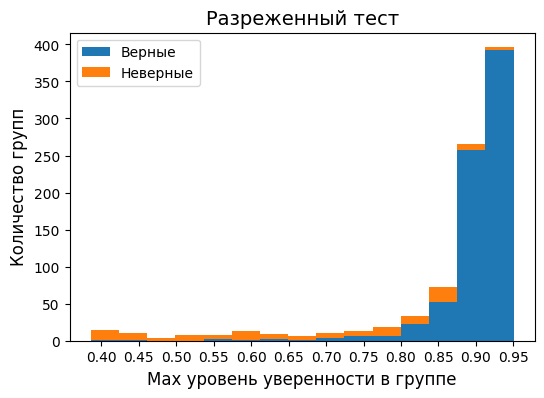

In [65]:
plt.figure(figsize=(6, 4))
plt.hist([conf_is_matched, conf_not_matched], bins=15, stacked=True, label=['Верные', 'Неверные'])
plt.xlabel("Max уровень уверенности в группе", fontsize=12)
plt.ylabel("Количество групп", fontsize=12)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=15))
plt.title("Разреженный тест", fontsize=14)
plt.legend()

pred_median_length = int(np.median([len(g) for g in pred_groups]))
pred_mean_length = int(np.mean([len(g) for g in pred_groups]))
print(f"Median group size: {pred_median_length}")
print(f"Mean group size: {pred_mean_length}")

In [66]:
bins = np.linspace(0.3, 1.0, 15)

In [67]:
rate_arr = []
for b in bins[:-2]:
    matched_cnt = len([c for c in conf_is_matched if b <= c < b + 0.05])
    unmatched_cnt = len([c for c in conf_not_matched if b <= c < b + 0.05])
    rate_arr.append(unmatched_cnt / (matched_cnt + unmatched_cnt + 1))

In [68]:
rate_arr += [0, 0]

In [69]:
rate_arr

[0.0,
 0.8333333333333334,
 0.8235294117647058,
 0.875,
 0.9166666666666666,
 0.7333333333333333,
 0.7857142857142857,
 0.625,
 0.6666666666666666,
 0.5,
 0.28,
 0.10714285714285714,
 0.013409961685823755,
 0,
 0]

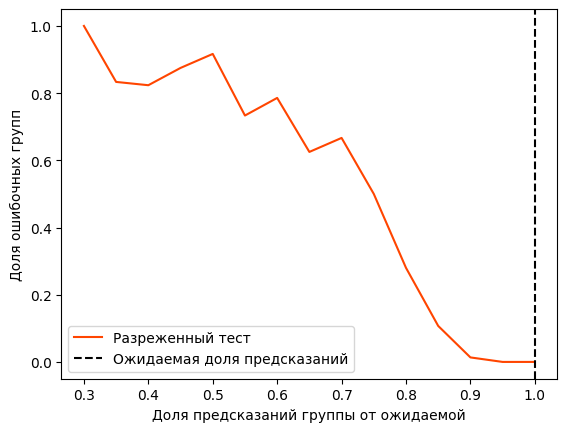

In [70]:
rate_arr[0] = 1
plt.plot(bins, rate_arr, label='Разреженный тест', color='orangered')
plt.axvline(x=1, color='k', linestyle='--', label='Ожидаемая доля предсказаний')
plt.xlabel("Доля предсказаний группы от ожидаемой")
plt.ylabel("Доля ошибочных групп")
plt.legend()

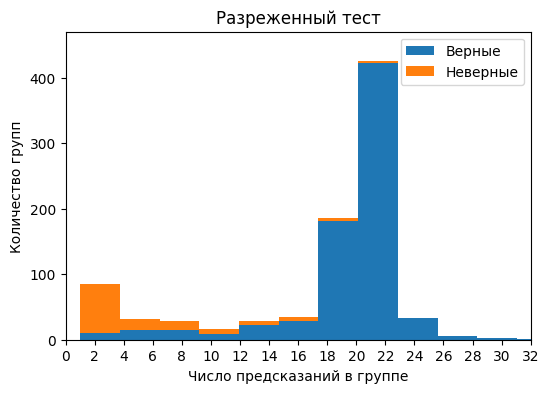

In [71]:
plt.figure(figsize=(6, 4))
plt.hist([len_is_matched, len_not_matched], bins=15, stacked=True, label=['Верные', 'Неверные'])
plt.xlabel("Число предсказаний в группе")
plt.ylabel("Количество групп")
plt.ylim(0, 470)
plt.xlim(0, 32)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=20))
plt.title("Разреженный тест")
plt.legend()

In [98]:
print("Full matches:", sum([д >= median_length for д in len_is_matched])/len(len_is_matched))

Full matches: 0.27236315086782376


In [72]:
lengths, counts = np.unique(np.array(len_is_matched), return_counts=True)
matched_arr = np.zeros(33)
for l, c in zip(lengths, counts):
    if int(l) < 33:
        matched_arr[int(l)] = int(c)

In [73]:
lengths, counts = np.unique(np.array(len_not_matched), return_counts=True)
unmatched_arr = np.zeros(33)
for l, c in zip(lengths, counts):
    if int(l) < 33:
        unmatched_arr[int(l)] = int(c)

In [74]:
rate_arr = unmatched_arr / (matched_arr + unmatched_arr + 1)

In [75]:
print(rate_arr)

[0.         0.90384615 0.80769231 0.7        0.7        0.5
 0.27272727 0.38461538 0.42857143 0.45454545 0.55555556 0.33333333
 0.08333333 0.3        0.11111111 0.33333333 0.07692308 0.06666667
 0.05       0.04761905 0.01574803 0.00749064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


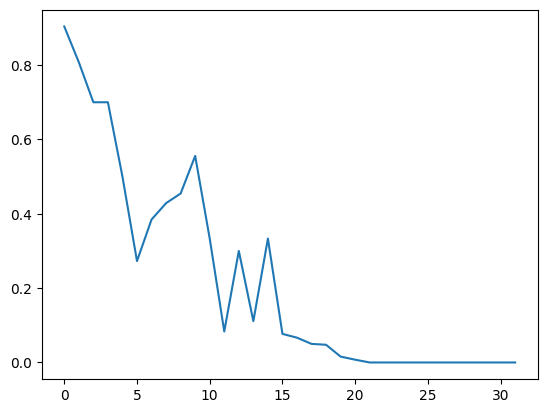

In [76]:
plt.plot(rate_arr[1:])

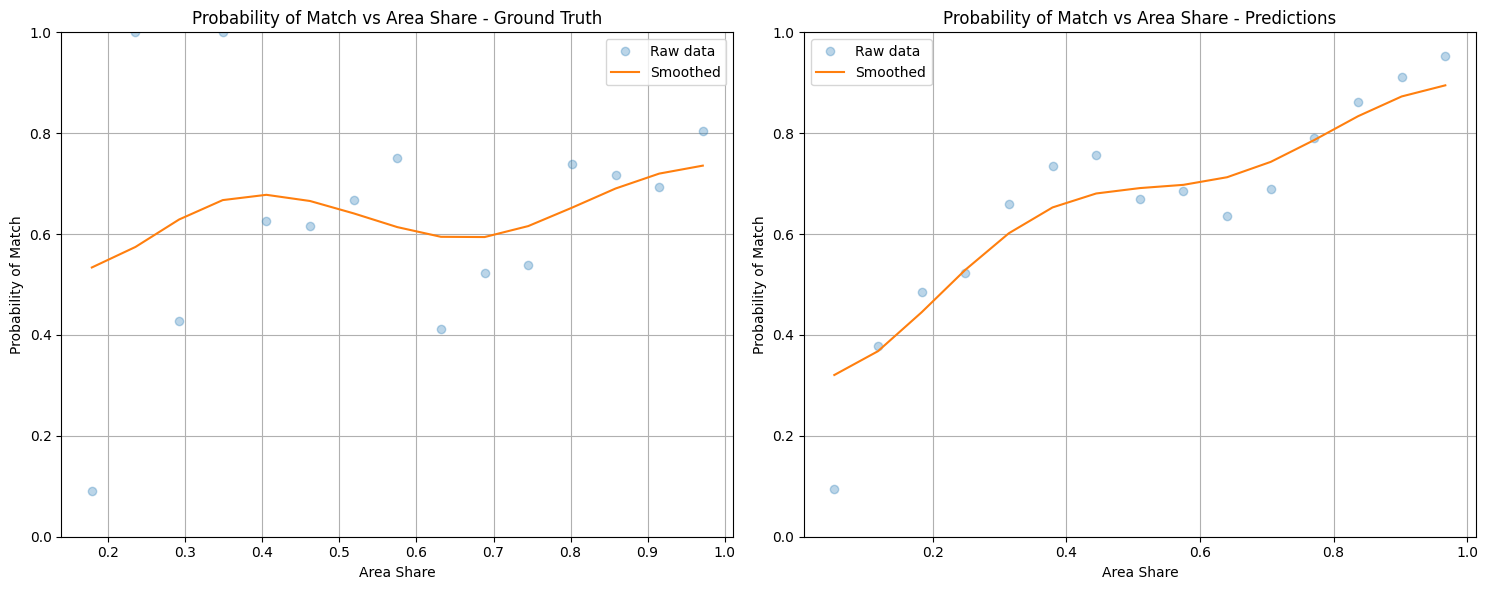

In [77]:
# Create subplots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_match_probability(gt_groups, 'Ground Truth')
plt.subplot(1, 2, 2)
plot_match_probability(pred_groups, 'Predictions')
plt.tight_layout()
plt.show()

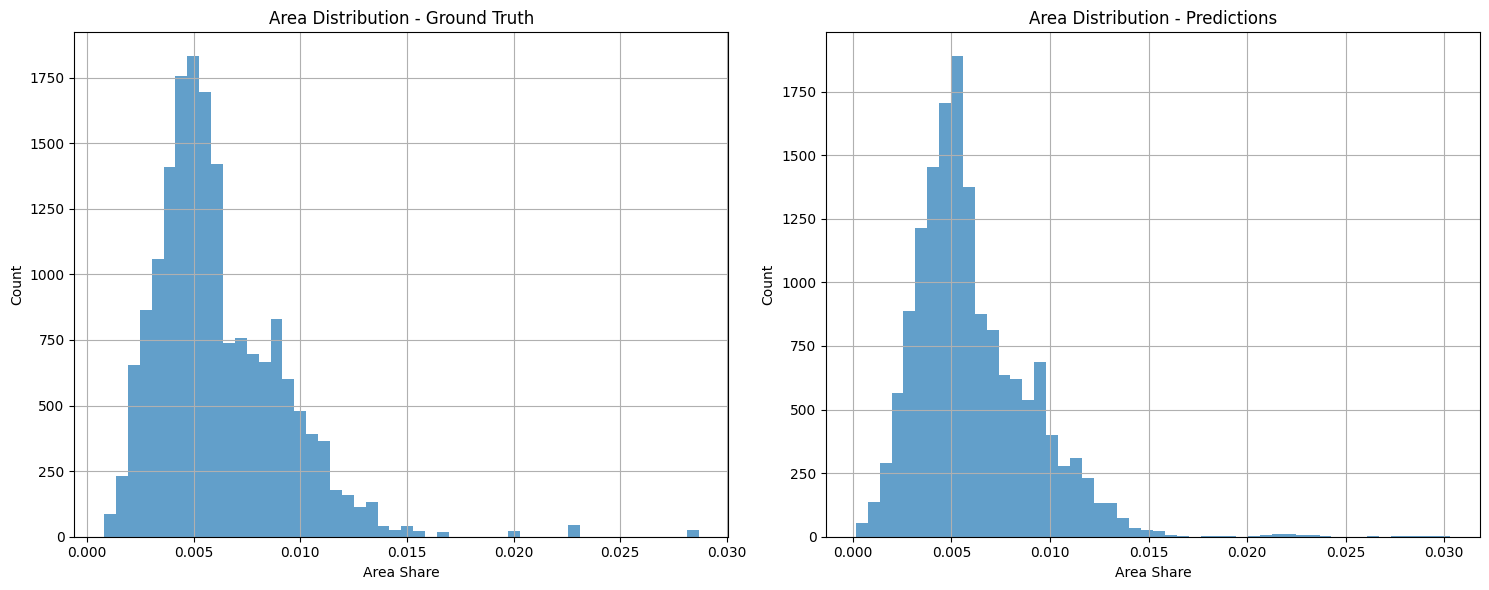

In [78]:
plot_area_distribution(gt_groups, pred_groups, config)

In [79]:
calculate_pcorr(gt_groups, pred_groups)

Dataset     Correlation      P-value
----------------------------------
GT               0.0703   1.8369e-20
Pred             0.2939  1.8205e-305
Total            0.1137   9.5268e-95


In [80]:
print("GT match probability:  ", float(get_match_probability(gt_groups, 0.0, 1.0)))
print("Pred match probability:", float(get_match_probability(pred_groups, 0.0, 1.0)))

GT match probability:   0.7943413622219662
Pred match probability: 0.8925705410302873


#### Все объекты

In [81]:
print("Per-mask precision:", (bpm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g]).mean()))
print("Per-obj precision:", (bpo_p := np.array([max(float(m['is_matched']) for m in g) for g in pred_groups]).mean()))

Per-mask precision: 0.8925705410302873
Per-obj precision: 0.8521046643913538


In [82]:
print("Per-mask recall:", (bpm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g]).mean()))
print("Per-obj recall:", (bpo_r := np.array([max(float(m['is_matched']) for m in g) for g in gt_groups]).mean()))

Per-mask recall: 0.7943413622219662
Per-obj recall: 0.952020202020202


In [83]:
print("Per-mask F1:", bpm_p * bpm_r / (bpm_p + bpm_r) * 2)
print("Per-obj F1:", bpo_p * bpo_r / (bpo_p + bpo_r) * 2)

Per-mask F1: 0.8405960003889712
Per-obj F1: 0.8992956860571956


#### Без краевых объектов

In [84]:
print("Per-mask precision:", (pm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g if not m['is_border']]).mean()))
print("Per-obj precision:", (po_p := np.array([max(float(m['is_matched']) for m in g if not m['is_border']) for g in pred_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask precision: 0.9065601736972705
Per-obj precision: 0.8752969121140143


In [85]:
print("Per-mask recall:", (pm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g if not m['is_border']]).mean()))
print("Per-obj recall:", (po_r := np.array([max([float(m['is_matched']) for m in g if not m['is_border']] + [0]) for g in gt_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask recall: 0.8616763387938
Per-obj recall: 0.9429657794676806


In [86]:
print("Per-mask F1:", pm_p * pm_r / (pm_p + pm_r) * 2)
print("Per-obj F1:", po_p * po_r / (po_p + po_r) * 2)

Per-mask F1: 0.8835486043292303
Per-obj F1: 0.9078721560076196


#### Доля ошибок классификации


In [87]:
print("GT per-mask ratio:", np.array([float(m['is_mask_matched']) for g in gt_groups for m in g if not m['is_matched']]).mean())
print("GT per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in gt_groups if max(float(m['is_matched']) for m in g) == False]).mean())

GT per-mask ratio: 0.03866629307929392
GT per-obj ratio: 0.2894736842105263


In [88]:
print("Pred per-mask ratio:", np.array([float(m['is_mask_matched']) for g in pred_groups for m in g if not m['is_matched']]).mean())
print("Pred per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in pred_groups if max(float(m['is_matched']) for m in g) == False]).mean())

Pred per-mask ratio: 0.0963855421686747
Pred per-obj ratio: 0.1076923076923077


### Гипотеза о зависимости обрезанности и качества распознавания

In [89]:
gt_is_matched = []
gt_is_border = []
pred_is_matched = []
pred_is_border = []

for group in gt_groups:
    for obj in group:
        gt_is_matched.append(obj['is_matched'])
        gt_is_border.append(obj['is_border'])
        
for group in pred_groups:
    for obj in group:
        pred_is_matched.append(obj['is_matched'])
        pred_is_border.append(obj['is_border'])

is_matched = {"Pred": pred_is_matched, "GT": gt_is_matched, 'Total': pred_is_matched + gt_is_matched}
is_border = {"Pred": pred_is_border, "GT": gt_is_border, 'Total': pred_is_border + gt_is_border}

In [90]:
from scipy.stats import spearmanr

print("| Sample | Spearman correlation | p-value               |")
print("|--------|----------------------|-----------------------|")
for sample in ['GT', 'Pred', 'Total']:
    corr, p_value = spearmanr(is_border[sample], is_matched[sample])
    print(f"| {sample:>6} | {corr:>20.6f} | {p_value:>21} |")

| Sample | Spearman correlation | p-value               |
|--------|----------------------|-----------------------|
|     GT |            -0.317795 |                   0.0 |
|   Pred |            -0.101478 | 1.1783237553647425e-36 |
|  Total |            -0.240484 |                   0.0 |


### Количество объектов, предсказанных только по краевым объектам

In [91]:
def get_border_only_matched(groups):
    border_only_matched = []
    border_only_matched_ids = []
    for i, group in enumerate(groups):
        border_matched = False
        non_border_matched = False
        non_border_found = False
        for obj in group:
            if obj['is_matched']:
                if obj['is_border']:
                    border_matched = True
                else:
                    non_border_matched = True
            if not obj['is_border']:
                non_border_found = True
        if border_matched and not non_border_matched and non_border_found:
            border_only_matched.append(group)
            border_only_matched_ids.append(i)
    return border_only_matched, border_only_matched_ids

In [92]:
gt_border_only, gt_border_ids = get_border_only_matched(gt_groups)
pred_border_only, pred_border_ids = get_border_only_matched(pred_groups)

In [93]:
print("GT:", len(gt_border_only), "elements", "out of", len(gt_groups), f"({len(gt_border_only) / len(gt_groups) * 100:.2f}%)")
print("Pred:", len(pred_border_only), "elements", "out of", len(pred_groups), f"({len(pred_border_only) / len(pred_groups) * 100:.2f}%)")

GT: 8 elements out of 792 (1.01%)
Pred: 7 elements out of 879 (0.80%)


### Пороговая интеграция

In [94]:
def find_best_int_thr(border : bool):
    thresholds = range(1, median_length + 1)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        precision = calculate_integrated_precision(pred_groups, threshold, border)
        recall = calculate_integrated_recall(gt_groups, threshold, border)
        f1 = 2 * (precision * recall) / (precision + recall)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold (Border: {border})')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

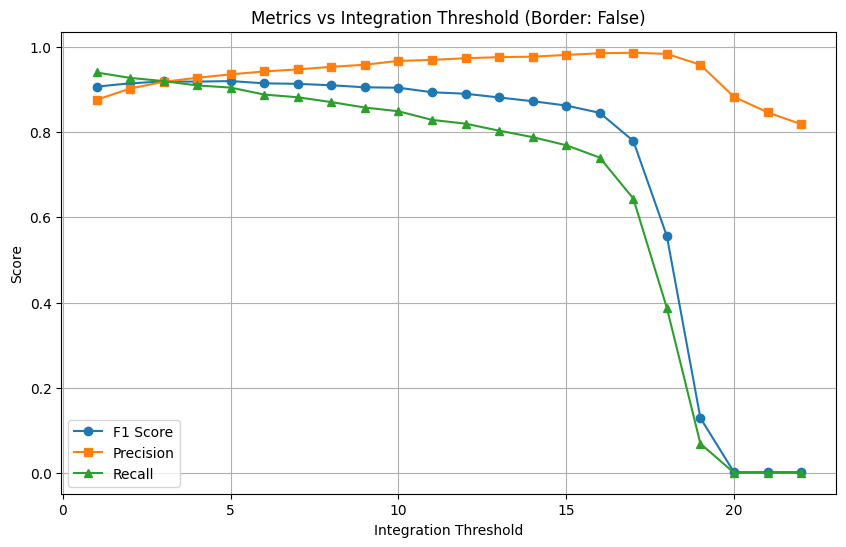

Max F1: 0.919 at threshold 5


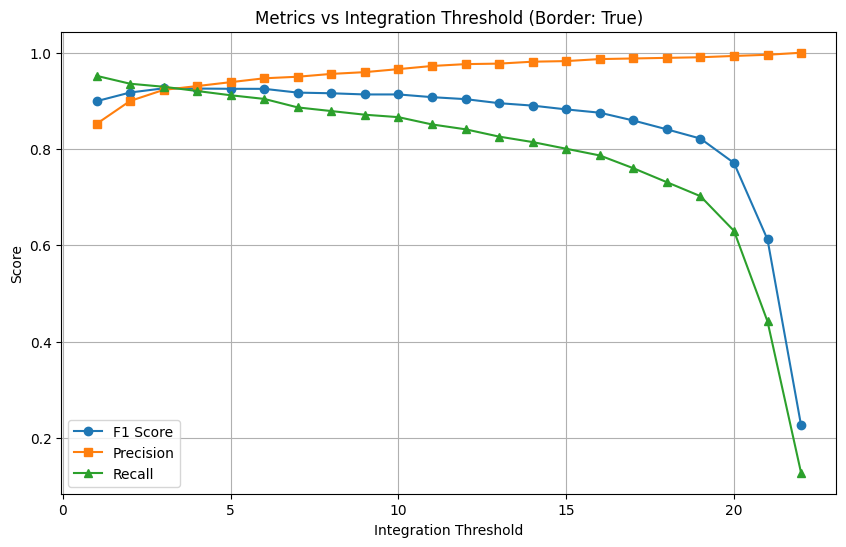

Max F1: 0.926 at threshold 3


In [95]:
find_best_int_thr(border=False)
find_best_int_thr(border=True)